In [15]:
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
import os

class NotebookOscillator:
    def __init__(self, **kwards):
        self.simulator_path = "./oscillator_simulator"
        self.config = {
            "initial_position": 10.0,
            "initial_velocity": 0.0,
            "dt": 0.001,
            "w": 10.0,
            "gamma": 1.0,
            "simulation_time": 50.0,
            "output_file": "results.csv",
            "method": "RK4",
            "equation": "MathPendulum"
        }
        self.set_parameters(**kwards)
        self.results = None
    
    def compile_simulator(self):
        result = subprocess.run([
            "g++", "-std=c++17", "-O3", "oscillator.cpp", 
            "-o", self.simulator_path
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симулятор успешно скомпилирован!"))
            return True
        else:
            display(Markdown("Ошибка компиляции:"))
            print(result.stderr)
            return False
    
    def set_parameters(self, **kwargs):
        for key, value in kwargs.items():
            if key in self.config:
                self.config[key] = value
    
    def show_parameters(self):
        display(Markdown("Текущие параметры симуляции"))
        params_df = pd.DataFrame([self.config])
        display(params_df)
    
    def run_simulation(self, config_file="config.json"):
        # Проверяем наличие симулятора
        if not os.path.exists(self.simulator_path):
            if not self.compile_simulator():
                return False
        
        # Сохраняем конфигурацию
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)
                
        # Запускаем симуляцию
        result = subprocess.run([
            self.simulator_path, config_file
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симуляция завершена успешно!"))
            output_file = self.config["output_file"]
            df = pd.read_csv(output_file)
            self.results = df
            return True
        else:
            display(Markdown("Ошибка симуляции:"))
            print(result.stderr)
            return False
        
    
    def plot_results(self):                
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Положение от времени
        ax1.plot(self.results['time'], self.results['position'], 'b-', linewidth=2, label= self.config['method'])
        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Скорость от времени
        ax2.plot(self.results['time'], self.results['velocity'], 'r-', linewidth=2, label= self.config['method'])
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Фазовый портрет
        ax3.plot(self.results['position'], self.results['velocity'], 'g-', linewidth=1, label= self.config['method'])
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # Энергия
        ax4.plot(self.results['time'], self.results['energy'], 'purple', linewidth=2, label= self.config['method'])
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        
    def compare_methods(self):
        methods = [ "Hoina", "Euler"]
        colors = [ 'r', 'g']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        for i in range(len(methods)):
            self.set_parameters(method=methods[i], output_file=methods[i]+"Results.csv")
            self.run_simulation()

            ax1.plot(self.results['time'], self.results['position'], color = colors[i], linewidth=1, label= methods[i])
            ax2.plot(self.results['time'], self.results['velocity'], color = colors[i], linewidth=1, label= methods[i])
            ax3.plot(self.results['position'], self.results['velocity'], color = colors[i], linewidth=1, label= methods[i])
            ax4.plot(self.results['time'], self.results['energy'], color = colors[i], linewidth=1, label= methods[i])

        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.legend()
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        ax4.legend()


        plt.tight_layout()
        plt.show()

In [16]:
sim = NotebookOscillator()
sim.compile_simulator()

Симулятор успешно скомпилирован!

True

In [17]:
sim.set_parameters(
    initial_position=10.0,
    w=1.0,
    gamma=1.0,
    simulation_time=100.0,
    dt=0.1,
    equation="DampedPhysPendulum",
    method="RK4"
)

sim.show_parameters()

Текущие параметры симуляции

,initial_position,initial_velocity,dt,w,gamma,simulation_time,output_file,method,equation
0,10.0,0.0,0.1,1.0,1.0,100.0,results.csv,RK4,DampedPhysPendulum


Симуляция завершена успешно!

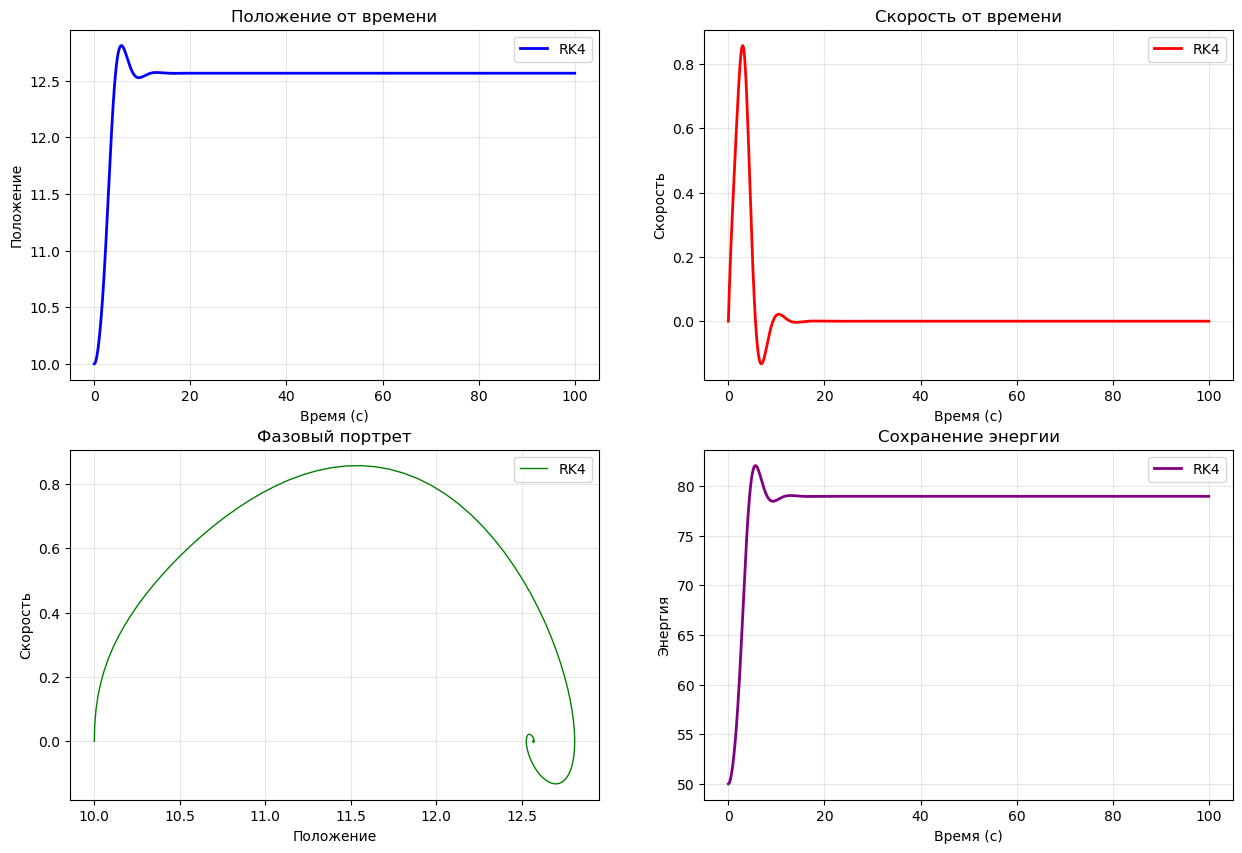

In [18]:
sim.run_simulation()   
sim.plot_results()

Симуляция завершена успешно!

Симуляция завершена успешно!

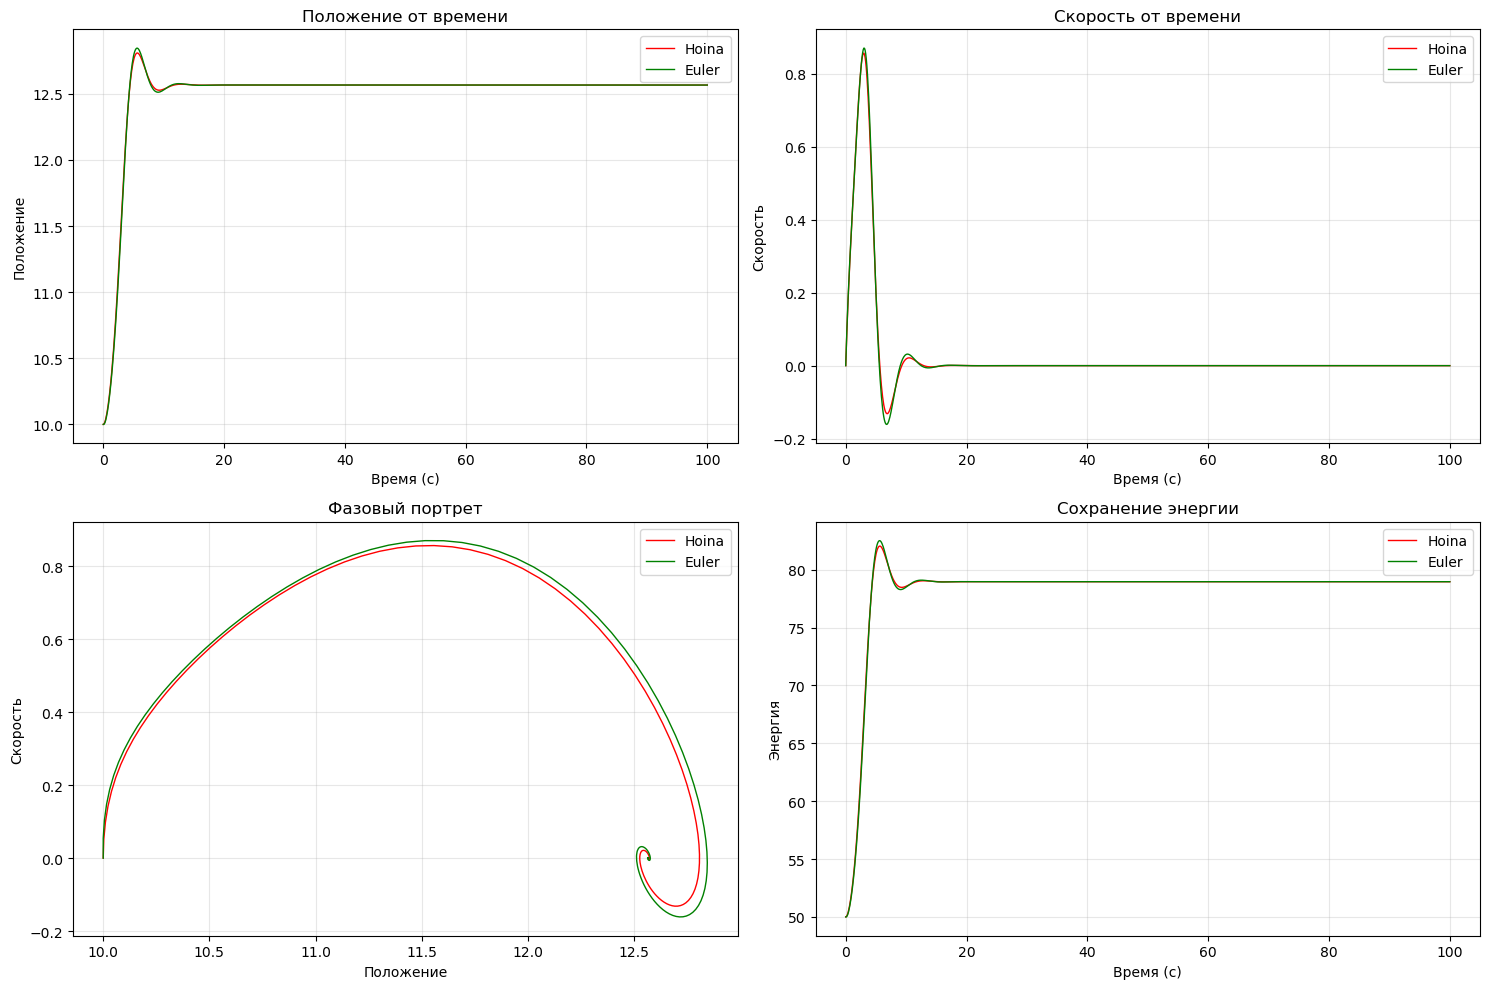

In [19]:
sim.compare_methods()